# Plot single graphs

In [1]:
from model_complex import Calibration, EpidData, FactoryBRModel
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def optuna_annealing_plot(epid_data, method, type):
    epid_data.get_wave_data(regime=type)
    data = epid_data.prepare_for_calibration()
    rho = epid_data.get_rho()//10

    if type == 'age':
        init_infect = [100, 100]
        model = FactoryBRModel.age_group()
        label = {0: '0-14 years', 1: '15+ years'}
    else:
        init_infect = [100]
        model = FactoryBRModel.total()
        label = {0: 'total'}

    calibration = Calibration(init_infect, model, data, rho)

    if method == 'annealing':
        alpha, beta = calibration.annealing_calibration()
    else:
        alpha, beta = calibration.optuna_calibration()

    res = model.get_result()
    plot_data = epid_data.prepare_for_plot()

    color = {0: 'blue', 1: 'orange'}
    for i in range(len(res)):
        d = plot_data[:, i]
        m = res[i]
        l = max(max(m),max(d))/(len(res)+1)
        plt.text(0, l+i*l, f'R2_{i}: {round(r2_score(d, m),2)}')
        plt.plot(m, label=label[i], color=color[i])
        plt.plot(d, '--o', color=color[i])
    plt.title(f"{method.capitalize()}, {type.capitalize()}")
    plt.legend()
    plt.plot()
    

def abc_mcmc_plot(epid_data, method, type, epsilon=3000, with_rho=False):
    epid_data.get_wave_data(regime=type)
    data = epid_data.prepare_for_calibration()
    rho = epid_data.get_rho()//10

    if type == 'age':
        init_infect = [100, 100]
        model = FactoryBRModel.age_group()
        label = {0: '0-14 years', 1: '15+ years'}
    else:
        init_infect = [100]
        model = FactoryBRModel.total()
        label = {0: 'total'}

    calibration = Calibration(init_infect, model, data, rho)

    if method == 'abc':
        alpha, beta = calibration.abc_calibration(epsilon=epsilon, with_rho=with_rho)
    else:
        alpha, beta = calibration.mcmc_calibration(epsilon=epsilon, with_rho=with_rho)

    color = {0: 'blue', 1: 'orange'}

    for a, b in zip(zip(*alpha), zip(*beta)):

        model.simulate(
            alpha=a, 
            beta=b, 
            initial_infectious=init_infect, 
            rho=rho, 
            modeling_duration=len(data)//len(a)
        )
        res = model.get_result()
        for i in range(len(res)):
            plt.plot(res[i], lw=0.3, alpha=0.5, color=color[i])

    model.simulate(
        alpha=[a.mean() for a in alpha], 
        beta=[b.mean() for b in beta], 
        initial_infectious=init_infect, 
        rho=rho, 
        modeling_duration=len(data)//len(init_infect)
    )

    res = model.get_result()
    plot_data = epid_data.prepare_for_plot()
    
    for i in range(len(res)):
        d = plot_data[:, i]
        m = res[i]
        l = max(max(m),max(d))/(len(res)+1)
        plt.text(0, l+i*l, f'R2_{i}: {round(r2_score(d, m),2)}')
        plt.plot(m, label=label[i], color=color[i])
        plt.plot(d, '--o', color=color[i])
    plt.title(f"ABC, {type.capitalize()}")
    plt.legend()
    plt.plot()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Single example

In [3]:
epid_data = EpidData(city='samara', path='./', 
                start_time='01-07-2015', end_time='20-06-2016')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


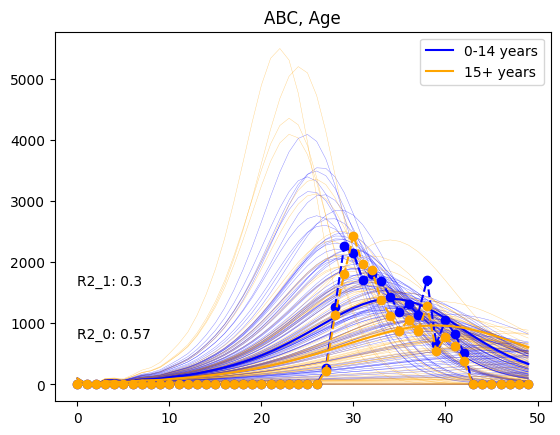

In [4]:
abc_mcmc_plot(epid_data, 'abc', 'age', epsilon=1000)

In [ ]:
abc_mcmc_plot(epid_data, 'abc', 'age', epsilon=1000, with_rho=[300_000, 700_000])

In [ ]:
optuna_annealing_plot(epid_data, 'annealing', 'age')

# Plot multiple graphics

In [6]:
from model_complex import Calibration, EpidData, FactoryBRModel
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import time

def opt_ann_plots(st_year, years, type, city, method):

    if type == 'age':
        groups = 2
        legend_dict = {0: '0-14 years', 1: '15+ years'}
        model = FactoryBRModel.age_group()
        init_infect = [100, 100]
    else:
        groups = 1
        legend_dict = {0: 'total'}
        model = FactoryBRModel.total()
        init_infect = [100]
        

    fig, ax = plt.subplots(years, groups, figsize=(groups*5, years*2.5))

    if groups == 1:
        for i in range(years):
            ax[i] = [ax[i]]

    color = {0: 'blue', 1: 'orange'}
    main_color = {0: 'red', 1: 'green'}

    for i in range(years):
        epid_data = EpidData(city=city, path='./', 
                    start_time=f'01-07-{st_year + i}', end_time=f'20-06-{st_year + i + 1}')
        epid_data.get_wave_data(regime=type)
        data = epid_data.prepare_for_calibration()
        rho = epid_data.get_rho()//10

        calibration = Calibration(init_infect, model, data, rho)

        start = time.time()

        if method == 'annealing':
            alpha, beta = calibration.annealing_calibration()
        else:
            alpha, beta = calibration.optuna_calibration()

        res = model.get_result()
        plot_data = epid_data.prepare_for_plot()

        for j in range(len(res)):
            d = plot_data[:, j]
            m = res[j]
            l = max(max(m),max(d))/3
            ax[i][j].text(0, l, f'Time: {round(time.time()-start, 0)}')
            ax[i][j].text(0, 2*l, f'R2_{j}: {round(r2_score(d, m),2)}')
            ax[i][j].plot(m, label=legend_dict[j], color=main_color[j])
            ax[i][j].plot([i for i in range(len(d))], d, '--o', color=color[j])
            ax[i][j].set_title(f'{legend_dict[j]} {st_year + i}-{st_year + 1 + i}')
            ax[i][j].set_xlabel('Неделя')
            ax[i][j].set_ylabel('Кол-во больных')


    plt.tight_layout() 
    plt.show()





def abc_mcmc_plots(st_year, years, method, type, city, epsilon=3000):

    if type == 'age':
        groups = 2
        legend_dict = {0: '0-14 years', 1: '15+ years'}
        model = FactoryBRModel.age_group()
        init_infect = [100, 100]
    else:
        groups = 1
        legend_dict = {0: 'total'}
        model = FactoryBRModel.total()
        init_infect = [100]
        

    fig, ax = plt.subplots(years, groups, figsize=(groups*5, years*2.5))

    if groups == 1:
        for i in range(years):
            ax[i] = [ax[i]]

    color = {0: 'blue', 1: 'orange'}
    main_color = {0: 'red', 1: 'green'}

    for i in range(years):
        epid_data = EpidData(city=city, path='./', 
                    start_time=f'01-07-{st_year + i}', end_time=f'20-06-{st_year + i + 1}')
        epid_data.get_wave_data(regime=type)
        data = epid_data.prepare_for_calibration()
        rho = epid_data.get_rho()//10

        calibration = Calibration(init_infect, model, data, rho)

        start = time.time()
        
        if method == 'abc':
            alpha, beta = calibration.abc_calibration(epsilon=epsilon)
        else:
            alpha, beta = calibration.mcmc_calibration(epsilon=epsilon)


        for a, b in zip(zip(*alpha), zip(*beta)):

            model.simulate(
                alpha=a, 
                beta=b, 
                initial_infectious=init_infect, 
                rho=rho, 
                modeling_duration=len(data)//len(init_infect)
            )
            res = model.get_result()
            for j in range(len(res)):
                ax[i][j].plot(res[j], lw=0.3, alpha=0.5, color=color[j])

        model.simulate(
            alpha=[a.mean() for a in alpha], 
            beta=[b.mean() for b in beta], 
            initial_infectious=init_infect, 
            rho=rho, 
            modeling_duration=len(data)//len(init_infect)
        )

        res = model.get_result()
        plot_data = epid_data.prepare_for_plot()

        for j in range(len(res)):
            d = plot_data[:, j]
            m = res[j]
            l = max(max(m),max(d))/3
            ax[i][j].text(0, l, f'Time: {round(time.time()-start, 0)}')
            ax[i][j].text(0, 2*l, f'R2_{j}: {round(r2_score(d, m),2)}')
            ax[i][j].plot(m, label=legend_dict[j], color=main_color[j])
            ax[i][j].plot([i for i in range(len(d))], d, '--o', color=color[j])
            ax[i][j].set_title(f'{legend_dict[j]} {st_year + i}-{st_year + 1 + i}')
            ax[i][j].set_xlabel('Неделя')
            ax[i][j].set_ylabel('Кол-во больных')


    plt.tight_layout() 
    plt.show()



# Multiple example

In [ ]:
st_year = 2010
years = 5
method = 'mcmc'
type ='total'
city = 'samara'

abc_mcmc_plots(st_year, years, method, type, city, epsilon=1000)

In [ ]:
st_year = 2010
years = 10
type ='age'
city = 'samara'
method = 'annealing'

opt_ann_plots(st_year, years, type, city, method)

# For ICCS

In [5]:
from model_complex import Calibration, EpidData, FactoryBRModel
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
import numpy as np
import time

def total_plots(st_year, city, method):

    model = FactoryBRModel.total()
    init_infect = [100]
    legend_dict = 'total'
    data_color = 'orangered'
    main_color = 'royalblue' 

    fig, ax = plt.subplots(3, 3, figsize=(10, 10))


    for i in range(3):
        for j in range(3):
            epid_data = EpidData(
                    city=city, 
                    path='./', 
                    start_time=f'01-07-{st_year + i*3 + j}', 
                    end_time=f'20-06-{st_year + i*3 + j + 1}'
                )
            
            epid_data.get_wave_data(regime='total')
            data = epid_data.prepare_for_calibration()
            rho = epid_data.get_rho()//10

            calibration = Calibration(init_infect, model, data, rho)

            start = time.time()

            if method == 'optuna':
                alpha, beta = calibration.optuna_calibration()
            elif method == 'abc':
                alpha, beta = calibration.abc_calibration()
            elif method == 'mcmc':
                alpha, beta = calibration.mcmc_calibration()
            else:
                alpha, beta = calibration.annealing_calibration()

            res = model.get_result()
            plot_data = epid_data.prepare_for_plot()


            d = plot_data[:, 0]
            m = res[0] 
            b = np.array([i for i in range(len(d))])
            start = b[d!=0][0]

            ax[i][j].text(36, 56000, f'$R^2$: {round(r2_score(d[start:], m[start:]),2)}')

            ax[i][j].plot([i for i in range(len(d))], d, '--o', color=data_color)
            ax[i][j].plot(m, label=legend_dict, color=main_color)
            ax[i][j].set_title(f'{st_year + i*3 + j}-{st_year + 1 + i*3 + j} season', fontsize=14)
            ax[i][j].set_yticks([i*1000 for i in range(0, 65, 10)])
            ax[i][j].set_yticklabels([str(i) for i in range(0, 65, 10)])
            ax[i][j].set_xlabel('Week', fontsize=13)
            ax[i][j].set_ylabel('Incidence, cases', fontsize=13)
            ax[i][j].set_ylim(0, 62000)
            ax[i][j].set_xlim(0, 50)
            ax[i][j].tick_params(axis='both', labelsize=12)
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 1))
            ax[i][j].yaxis.set_major_formatter(formatter)

            if method in ['abc', 'mcmc']:
                for a, b in zip(zip(*alpha), zip(*beta)):

                    model.simulate(
                        alpha=a, 
                        beta=b, 
                        initial_infectious=init_infect, 
                        rho=rho, 
                        modeling_duration=len(data)//len(init_infect)
                    )
                    res = model.get_result()

                    ax[i][j].plot(res[0], lw=0.3, alpha=0.5, color=main_color)

    fig.tight_layout() 
    fig.savefig(f'{method}_total.png', dpi=600, bbox_inches='tight')
    fig.savefig(f'{method}_total.pdf', bbox_inches='tight')
    plt.tight_layout() 
    plt.show()





def age_plots(st_year, years, method, type, city, epsilon=3000):

    if type == 'age':
        groups = 2
        legend_dict = {0: '0-14 years', 1: '15+ years'}
        model = FactoryBRModel.age_group()
        init_infect = [100, 100]
    else:
        groups = 1
        legend_dict = {0: 'total'}
        model = FactoryBRModel.total()
        init_infect = [100]
        

    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    # if groups == 1:
    #     for i in range(years):
    #         ax[i] = [ax[i]]

    # color = {0: 'blue', 1: 'orange'}
    # main_color = {0: 'red', 1: 'green'}

    # for i in range(years):
    #     epid_data = EpidData(city=city, path='./', 
    #                 start_time=f'01-07-{st_year + i}', end_time=f'20-06-{st_year + i + 1}')
    #     epid_data.get_wave_data(regime=type)
    #     data = epid_data.prepare_for_calibration()
    #     rho = epid_data.get_rho()//10

    #     calibration = Calibration(init_infect, model, data, rho)

    #     start = time.time()
        
    #     if method == 'abc':
    #         alpha, beta = calibration.abc_calibration(epsilon=epsilon)
    #     else:
    #         alpha, beta = calibration.mcmc_calibration(epsilon=epsilon)


    #     for a, b in zip(zip(*alpha), zip(*beta)):

    #         model.simulate(
    #             alpha=a, 
    #             beta=b, 
    #             initial_infectious=init_infect, 
    #             rho=rho, 
    #             modeling_duration=len(data)//len(init_infect)
    #         )
    #         res = model.get_result()
    #         for j in range(len(res)):
    #             ax[i][j].plot(res[j], lw=0.3, alpha=0.5, color=color[j])

    #     model.simulate(
    #         alpha=[a.mean() for a in alpha], 
    #         beta=[b.mean() for b in beta], 
    #         initial_infectious=init_infect, 
    #         rho=rho, 
    #         modeling_duration=len(data)//len(init_infect)
    #     )

    #     res = model.get_result()
    #     plot_data = epid_data.prepare_for_plot()

    #     for j in range(len(res)):
    #         d = plot_data[:, j]
    #         m = res[j]
    #         l = max(max(m),max(d))/3
    #         ax[i][j].text(0, l, f'Time: {round(time.time()-start, 0)}')
    #         ax[i][j].text(0, 2*l, f'R2_{j}: {round(r2_score(d, m),2)}')
    #         ax[i][j].plot(m, label=legend_dict[j], color=main_color[j])
    #         ax[i][j].plot([i for i in range(len(d))], d, '--o', color=color[j])
    #         ax[i][j].set_title(f'{legend_dict[j]} {st_year + i}-{st_year + 1 + i}')
    #         ax[i][j].set_xlabel('Неделя')
    #         ax[i][j].set_ylabel('Кол-во больных')


    plt.tight_layout() 
    plt.show()



Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta]
Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [sim]
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta]
Sampling 4 chains for 2_500 tune and 500 draw iterations (10_000 + 2_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. S

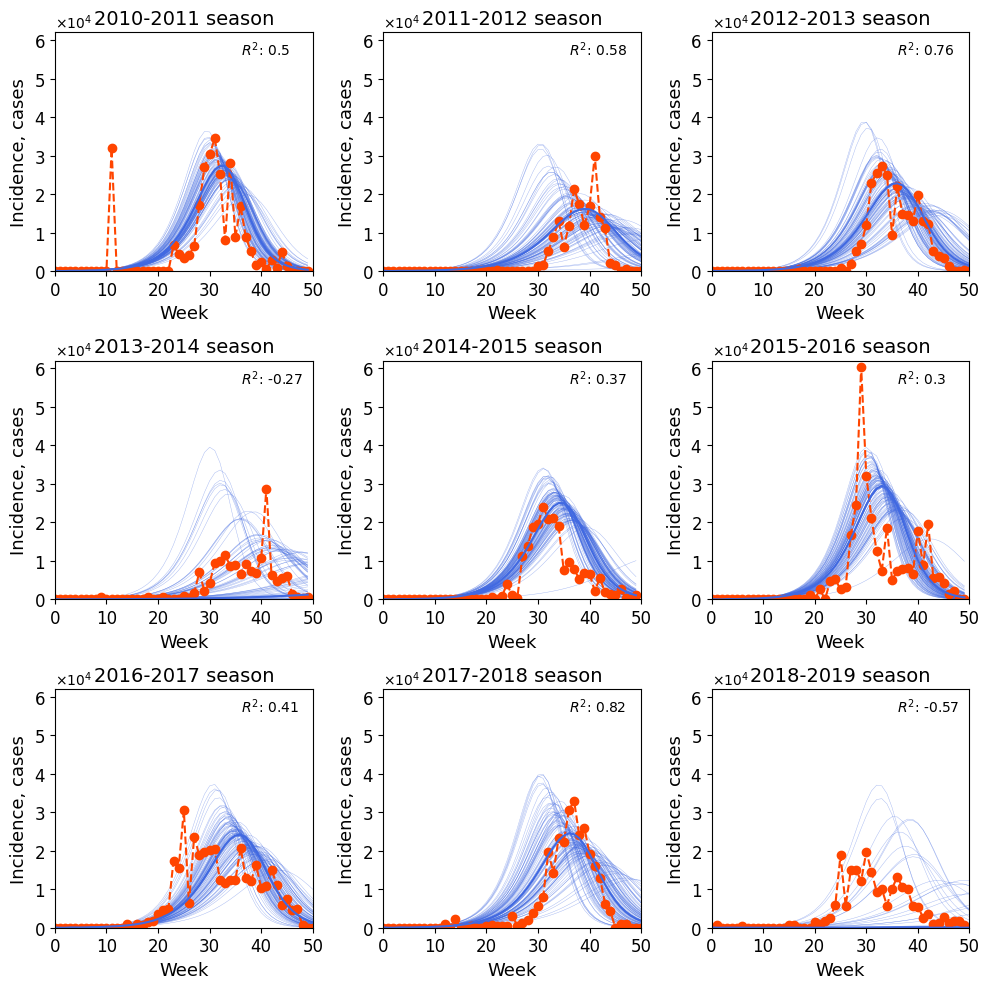

In [4]:
total_plots(2010, 'spb', 'mcmc')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/timofei/Desktop/model_complex/.venv/lib/python3.10/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


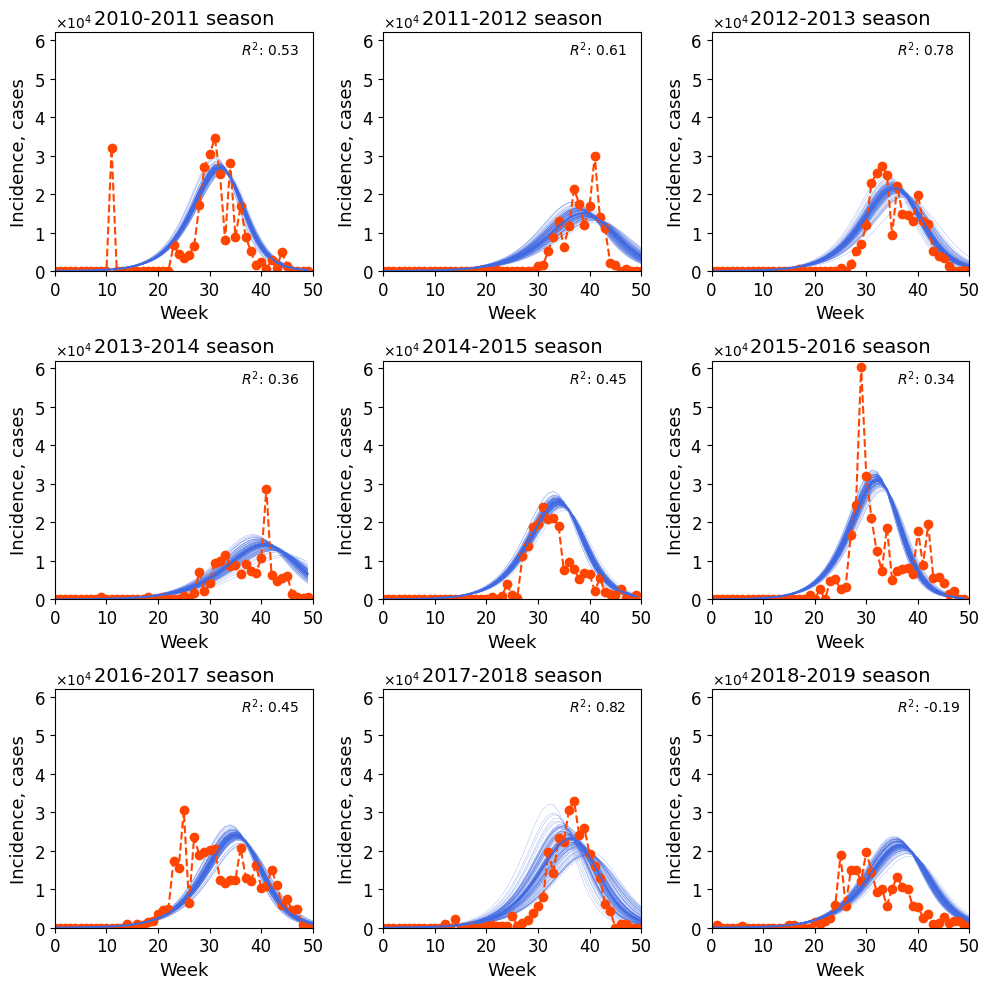

In [5]:
total_plots(2010, 'spb', 'abc')

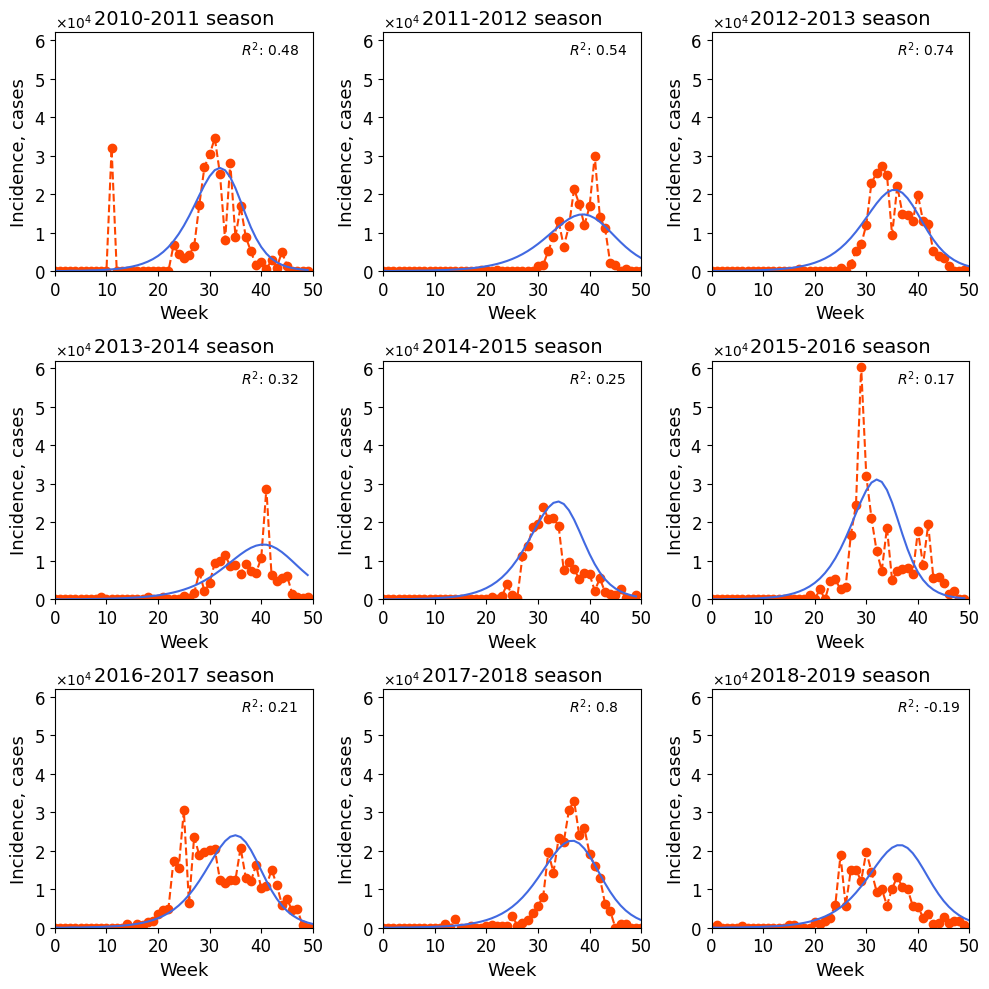

In [6]:
total_plots(2010, 'spb', 'annealing')

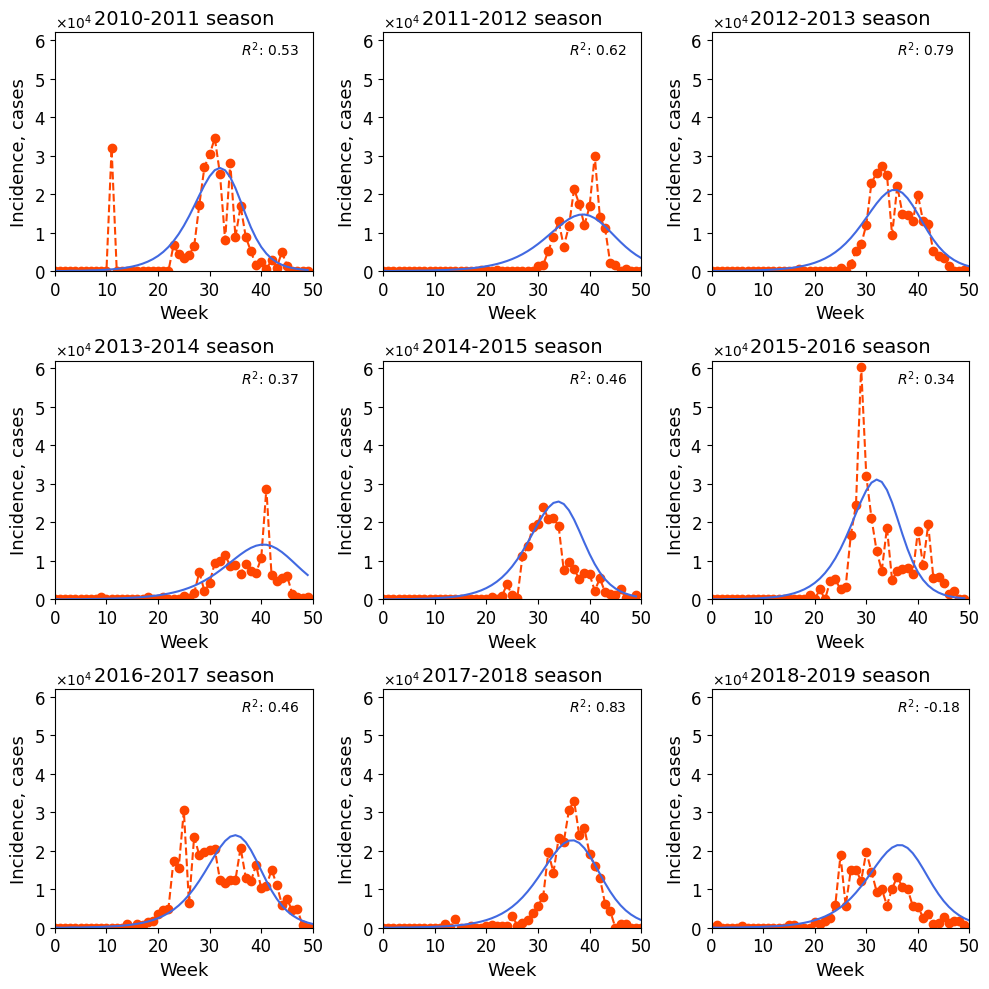

In [6]:
total_plots(2010, 'spb', 'annealing')

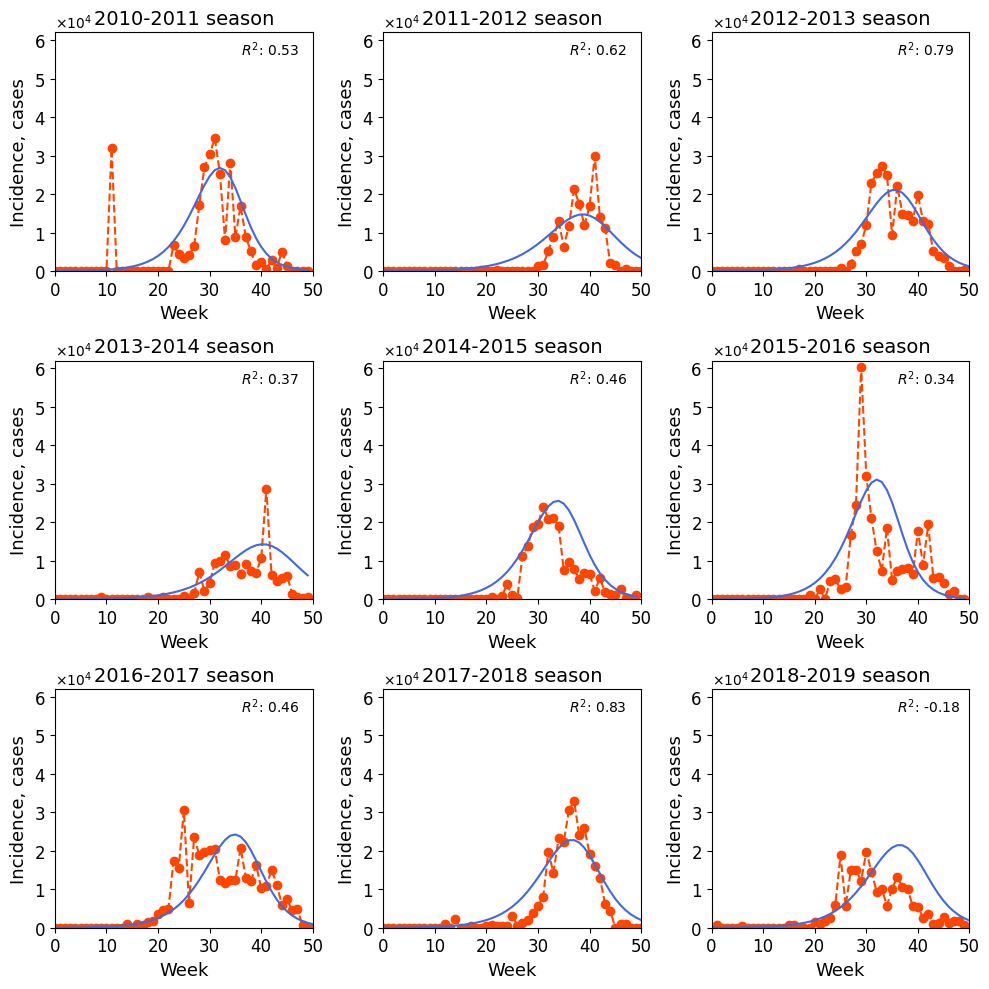

In [7]:
total_plots(2010, 'spb', 'optuna')

# Forecast

In [1]:
from model_complex import Forecats, FactoryBRModel, EpidData, Calibration
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import r2_score
import csv

def forecast_plot(type, st_time, end_time, end_prog, city, method):
    epid_data = EpidData(city=city, path='./', 
                    start_time=st_time, end_time=end_time)
    epid_data.get_wave_data(regime=type)
    data = epid_data.prepare_for_calibration()
    rho = epid_data.get_rho()//10
    plot_data = epid_data.prepare_for_plot()

    if type == 'age':
        init_infect = [100, 100]
        model = FactoryBRModel.age_group()
        label = {0: '0-14 years', 1: '15+ years'}
    else:
        init_infect = [100]
        model = FactoryBRModel.total()
        label = {0: 'total'}

    calibration = Calibration(init_infect, model, data, rho)

    if method == 'mcmc':
        alpha, beta = calibration.mcmc_calibration()
    else:
        alpha, beta = calibration.abc_calibration()

    dur = (datetime.datetime.strptime(end_prog, "%d-%m-%Y") - datetime.datetime.strptime(end_time, "%d-%m-%Y")).days//7

    Res = Forecats(data, model, init_infect, alpha, beta, rho, dur).forecast()

    color = {0: 'blue', 1: 'orange'}

    epid_data = EpidData(city=city, path='./', 
                    start_time=end_time, end_time=end_prog)
    epid_data.get_wave_data(regime=type)
    new_plot_data = epid_data.prepare_for_plot()

    model.simulate(
        alpha=[a.mean() for a in alpha], 
        beta=[b.mean() for b in beta], 
        initial_infectious=init_infect, 
        rho=rho, 
        modeling_duration=len(data)//len(init_infect)
    )

    res = model.get_result()

    model.simulate(
        alpha=[a.mean() for a in alpha], 
        beta=[b.mean() for b in beta], 
        initial_infectious=init_infect, 
        rho=rho, 
        modeling_duration=(len(data)//len(init_infect) +len(new_plot_data[:,0]))
    )

    new_res = model.get_result()

    return plot_data, new_plot_data, res, new_res, Res



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
times = [
    ['01-07-2010', '20-01-2011', '30-06-2011'],
    ['01-07-2015', '20-01-2016', '30-06-2016'],
    ['01-08-2012', '20-03-2013', '30-06-2013'],
    ['01-08-2013', '20-03-2014', '30-06-2014'],
    ['01-10-2011', '10-04-2012', '30-06-2012']
]

In [ ]:

import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(times)):
        start, end_time, end = times[i]
        label_fontsize = 18
        tick_fontsize = 16
        type = 'age'
        city = 'spb'
        method = 'abc'

        start_date = np.datetime64(f'{start.split("-")[2]}-{start.split("-")[1]}-{start.split("-")[0]}')
        end_date = np.datetime64(f'{end.split("-")[2]}-{end.split("-")[1]}-{end.split("-")[0]}')


        # Generate an array of dates with a weekly step
        date_array = np.arange(start_date, end_date + np.timedelta64(1, 'D'), np.timedelta64(1, 'W'))

        plot_data, new_plot_data, res, new_res, Res = forecast_plot(type, start, end_time, end, city, method)
        r2 = []
        data_lab = {0: '0-14', 1:'15+'}
        age_color = {0: 'forestgreen', 1: 'royalblue'}
        mod_col = {0: "crimson", 1: 'orangered'}
        for i in range(2):
                actual_data = plot_data[:, i]
                forecast_data = new_plot_data[:, i]
                model_curve = new_res[i]
                lower_ci = Res[i, :, 0]
                upper_ci = Res[i, :, 1]

                ax.set_xticklabels(date_array, rotation=20)
                ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as 'Month Year'
                # ax.set_ylim([-50, 35000])
                ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
                ax.set_ylabel('Заболеваемость, случаи', fontsize=label_fontsize)

                ax.plot(date_array[:len(actual_data)], actual_data, '--o', color=age_color[i], label='Доступные данные ' + data_lab[i])
                ax.fill_between(date_array[len(actual_data):-1], lower_ci[len(actual_data):], 
                                upper_ci[len(actual_data):], color=age_color[i], alpha=0.3, label='Доверительный интервал ' + data_lab[i])
                ax.plot(date_array[len(actual_data):-1], forecast_data, '--o', color=age_color[i], 
                        alpha=0.6, label='Прогнозируемые данные ' + data_lab[i])
                r2 += [round(r2_score(actual_data, model_curve[:len(actual_data)]), 2)]
                ax.plot(date_array[:-1], model_curve, linewidth=3, label='Модельная кривая ' + data_lab[i], color=age_color[i], alpha=0.8)
                ax.legend(fontsize=tick_fontsize)


        ax.set_title(r'$R^2' + '_{0-14}' + '={}$'.format(r2[0]) +  '  $R^2' + '_{15+}' +'={}$'.format(r2[1]), fontsize=label_fontsize)


        fig.savefig(r'Fplots/forecast_total_abc_{}-{}.png'.format(str(start_date), str(end_date)), dpi=400, bbox_inches='tight')
        fig.savefig(r'Fplots/forecast_total_abc_{}-{}.pdf'.format(str(start_date), str(end_date)), bbox_inches='tight')


Error: unsupported locale setting